In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data / 255.0, mnist.target.astype(int)  # Normalize and convert labels to int


c:\Users\Aspire_Lays\anaconda3\envs\ai\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
# Function to apply FGSM-like attack (adding uniform noise in one step)
def fgsm_attack(images, epsilon=0.3):
    noise = epsilon * np.sign(np.random.randn(*images.shape))
    adversarial_images = np.clip(images + noise, 0, 1)
    return adversarial_images

# Function to apply PGD-like attack (adding noise iteratively)
def pgd_attack(images, epsilon=0.3, alpha=0.03, iterations=30):
    adversarial_images = np.copy(images)
    for _ in range(iterations):
        noise = alpha * np.sign(np.random.randn(*images.shape))
        adversarial_images = np.clip(adversarial_images + noise, 0, 1)
    return adversarial_images

# Function to add Gaussian noise
def gaussian_noise_attack(images, mean=0, std=0.3):
    noise = np.random.normal(mean, std, images.shape)
    adversarial_images = np.clip(images + noise, 0, 1)
    return adversarial_images



In [8]:
# Select a few images to visualize
num_images = 4
indices = np.random.choice(len(X), num_images, replace=False)
arr_clean = X.values
clean_images = arr_clean[indices]



In [9]:
# Generate adversarial images
fgsm_images = fgsm_attack(clean_images)
pgd_images = pgd_attack(clean_images)
gaussian_images = gaussian_noise_attack(clean_images)



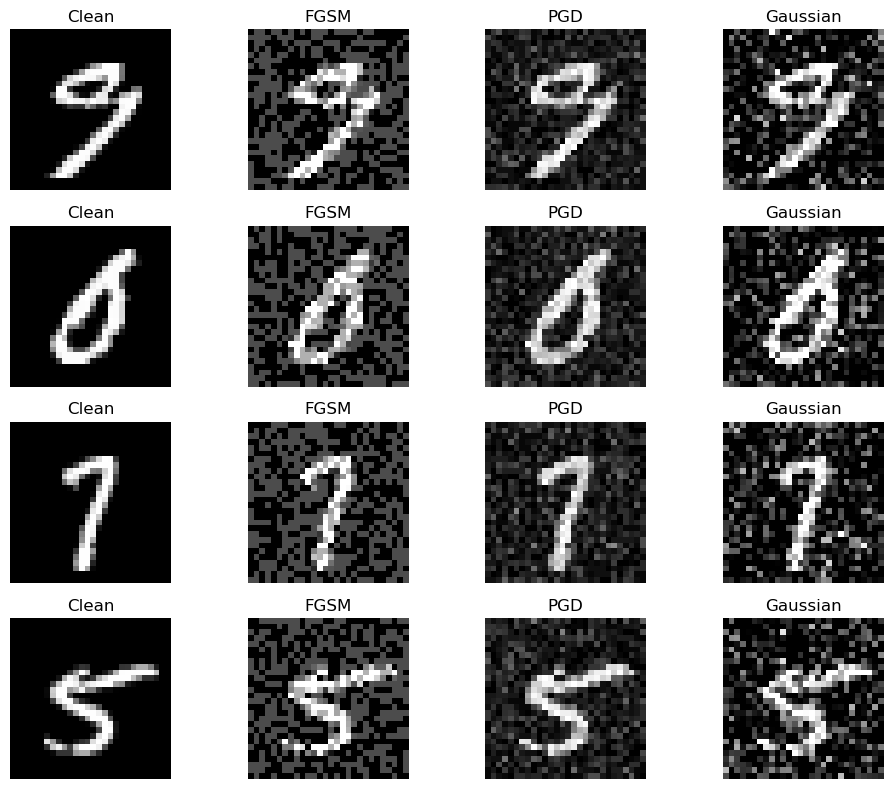

In [10]:
# Plotting the images side by side
fig, axes = plt.subplots(num_images, 4, figsize=(10, 8))
for i in range(num_images):
    # Plot clean image
    axes[i, 0].imshow(clean_images[i].reshape(28, 28), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Clean")

    # Plot FGSM image
    axes[i, 1].imshow(fgsm_images[i].reshape(28, 28), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title("FGSM")

    # Plot PGD image
    axes[i, 2].imshow(pgd_images[i].reshape(28, 28), cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title("PGD")

    # Plot Gaussian noise image
    axes[i, 3].imshow(gaussian_images[i].reshape(28, 28), cmap='gray')
    axes[i, 3].axis('off')
    axes[i, 3].set_title("Gaussian")

plt.tight_layout()
plt.show()


In [11]:
from sklearn import svm
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM model on the original dataset
svm_model = svm.SVC(kernel='rbf', gamma='scale')
svm_model.fit(X_train, y_train)

SVC()

In [36]:
import pickle

# Assume 'model' is your trained model
with open('svm_clean_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

In [12]:
# Evaluate the model on the clean test set
y_pred_clean = svm_model.predict(X_test)
accuracy_clean = accuracy_score(y_test, y_pred_clean)

In [13]:

# Apply adversarial attacks to the test set
X_test_fgsm = fgsm_attack(X_test)
X_test_pgd = pgd_attack(X_test)
X_test_gaussian = gaussian_noise_attack(X_test)



In [14]:
# Evaluate the model on the adversarial test sets
y_pred_fgsm = svm_model.predict(X_test_fgsm)
accuracy_fgsm = accuracy_score(y_test, y_pred_fgsm)

y_pred_pgd = svm_model.predict(X_test_pgd)
accuracy_pgd = accuracy_score(y_test, y_pred_pgd)

y_pred_gaussian = svm_model.predict(X_test_gaussian)
accuracy_gaussian = accuracy_score(y_test, y_pred_gaussian)

# Print the accuracies
print(f"Accuracy on Clean Test Set: {accuracy_clean:.4f}")
print(f"Accuracy on FGSM Attacked Test Set: {accuracy_fgsm:.4f}")
print(f"Accuracy on PGD Attacked Test Set: {accuracy_pgd:.4f}")
print(f"Accuracy on Gaussian Noise Test Set: {accuracy_gaussian:.4f}")



c:\Users\Aspire_Lays\anaconda3\envs\ai\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Accuracy on Clean Test Set: 0.9764
Accuracy on FGSM Attacked Test Set: 0.7977
Accuracy on PGD Attacked Test Set: 0.9037
Accuracy on Gaussian Noise Test Set: 0.8708


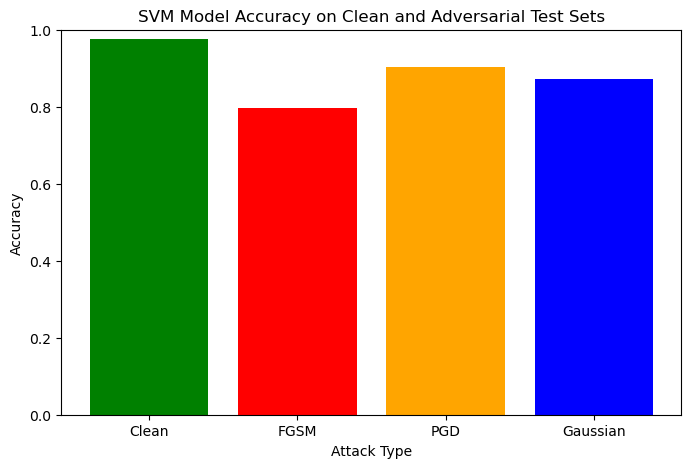

In [15]:
# Visualize the accuracies using a bar chart
attack_types = ['Clean', 'FGSM', 'PGD', 'Gaussian']
accuracies = [accuracy_clean, accuracy_fgsm, accuracy_pgd, accuracy_gaussian]

plt.figure(figsize=(8, 5))
plt.bar(attack_types, accuracies, color=['green', 'red', 'orange', 'blue'])
plt.xlabel('Attack Type')
plt.ylabel('Accuracy')
plt.title('SVM Model Accuracy on Clean and Adversarial Test Sets')
plt.ylim(0, 1)
plt.show()

In [16]:
from sklearn.utils import shuffle

# Combine clean and adversarial examples for adversarial training
X_train_adv = np.vstack([X_train, fgsm_attack(X_train), pgd_attack(X_train), gaussian_noise_attack(X_train)])
y_train_adv = np.hstack([y_train, y_train, y_train, y_train])

# Shuffle the augmented training data
X_train_adv, y_train_adv = shuffle(X_train_adv, y_train_adv, random_state=42)



In [17]:
# Retrain the SVM model on the combined dataset
svm_adv_model = svm.SVC(kernel='rbf', gamma='scale')
svm_adv_model.fit(X_train_adv, y_train_adv)

SVC()

In [18]:
# Evaluate the adversarially trained model on the adversarial test sets
accuracy_adv_fgsm = accuracy_score(y_test, svm_adv_model.predict(X_test_fgsm))
accuracy_adv_pgd = accuracy_score(y_test, svm_adv_model.predict(X_test_pgd))
accuracy_adv_gaussian = accuracy_score(y_test, svm_adv_model.predict(X_test_gaussian))

print(f"Adversarial Training Accuracy on FGSM Test Set: {accuracy_adv_fgsm:.4f}")
print(f"Adversarial Training Accuracy on PGD Test Set: {accuracy_adv_pgd:.4f}")
print(f"Adversarial Training Accuracy on Gaussian Noise Test Set: {accuracy_adv_gaussian:.4f}")


c:\Users\Aspire_Lays\anaconda3\envs\ai\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\Aspire_Lays\anaconda3\envs\ai\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Adversarial Training Accuracy on FGSM Test Set: 0.9672
Adversarial Training Accuracy on PGD Test Set: 0.9731
Adversarial Training Accuracy on Gaussian Noise Test Set: 0.9693


In [35]:
import pickle

# Assume 'model' is your trained model
with open('svm_adv_model.pkl', 'wb') as f:
    pickle.dump(svm_adv_model, f)


***Input Preprocessing (Feature Squeezing)***


In [46]:
from scipy.ndimage import gaussian_filter

# Apply Gaussian smoothing as a defense mechanism for MNIST images
def gaussian_smoothing(images, sigma=1):
    # Reshape the images from 1D (784,) to 2D (28, 28)
    smoothed_images = np.array([gaussian_filter(img.reshape(28, 28), sigma=sigma).flatten() for img in images])
    return smoothed_images

# Assuming you have X_test and adversarial versions like X_test_fgsm, X_test_pgd
# Apply the Gaussian smoothing defense to adversarial examples
X_test_fgsm_smooth = gaussian_smoothing(X_test_fgsm.to_numpy())
X_test_pgd_smooth = gaussian_smoothing(X_test_pgd)
X_test_gaussian_smooth = gaussian_smoothing(X_test_gaussian.to_numpy())

# Evaluate the model on smoothed adversarial examples (using SVM or other classifiers)
accuracy_smooth_fgsm = accuracy_score(y_test, svm_model.predict(X_test_fgsm_smooth))
accuracy_smooth_pgd = accuracy_score(y_test, svm_model.predict(X_test_pgd_smooth))
accuracy_smooth_gaussian = accuracy_score(y_test, svm_model.predict(X_test_gaussian_smooth))

print(f"Gaussian Smoothing Accuracy on FGSM Test Set: {accuracy_smooth_fgsm:.4f}")
print(f"Gaussian Smoothing Accuracy on PGD Test Set: {accuracy_smooth_pgd:.4f}")
print(f"Gaussian Smoothing Accuracy on Gaussian Noise Test Set: {accuracy_smooth_gaussian:.4f}")


c:\Users\Aspire_Lays\anaconda3\envs\ai\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\Aspire_Lays\anaconda3\envs\ai\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\Aspire_Lays\anaconda3\envs\ai\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Gaussian Smoothing Accuracy on FGSM Test Set: 0.6171
Gaussian Smoothing Accuracy on PGD Test Set: 0.7106
Gaussian Smoothing Accuracy on Gaussian Noise Test Set: 0.7007


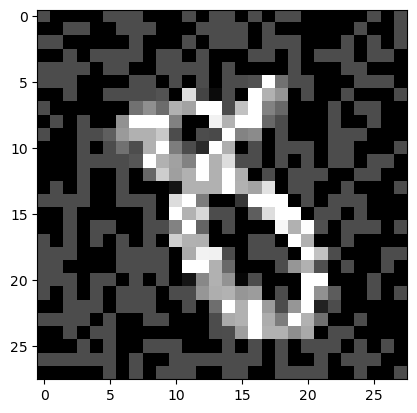

In [68]:
smooth_image = X_test_fgsm_smooth[2]
plt.imshow(smooth_image.reshape(28,28), cmap="gray")
plt.imshow(X_test_fgsm.to_numpy()[2].reshape(28,28), cmap="gray")
plt.show()

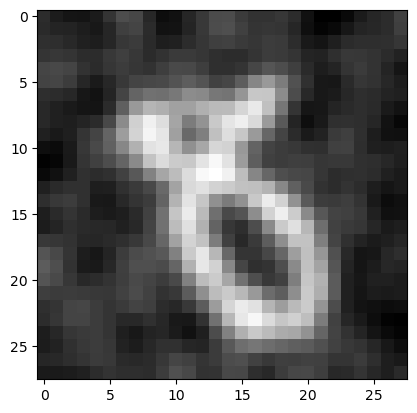

In [69]:
plt.imshow(smooth_image.reshape(28,28), cmap="gray")

***3. Defensive Distillation***

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from scipy.special import softmax

# Train a logistic regression model to create pseudo-labels
soft_labels_model = LogisticRegression(max_iter=100)
soft_labels_model.fit(X_train, y_train)

# Generate soft predictions for defensive distillation
pseudo_labels = softmax(soft_labels_model.decision_function(X_train) / 2, axis=1)

# Using pseudo-labels for training a new SVM
pseudo_labels_class = np.argmax(pseudo_labels, axis=1)
svm_distilled_model = svm.SVC(kernel='rbf', gamma='scale')
svm_distilled_model.fit(X_train, pseudo_labels_class)

# Evaluate the distilled SVM on adversarial test sets
accuracy_distilled_fgsm = accuracy_score(y_test, svm_distilled_model.predict(X_test_fgsm))
accuracy_distilled_pgd = accuracy_score(y_test, svm_distilled_model.predict(X_test_pgd))
accuracy_distilled_gaussian = accuracy_score(y_test, svm_distilled_model.predict(X_test_gaussian))

print(f"Defensive Distillation Accuracy on FGSM Test Set: {accuracy_distilled_fgsm:.4f}")
print(f"Defensive Distillation Accuracy on PGD Test Set: {accuracy_distilled_pgd:.4f}")
print(f"Defensive Distillation Accuracy on Gaussian Noise Test Set: {accuracy_distilled_gaussian:.4f}")


c:\Users\Aspire_Lays\anaconda3\envs\ai\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Aspire_Lays\anaconda3\envs\ai\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Defensive Distillation Accuracy on FGSM Test Set: 0.8140
Defensive Distillation Accuracy on PGD Test Set: 0.9267
Defensive Distillation Accuracy on Gaussian Noise Test Set: 0.8536


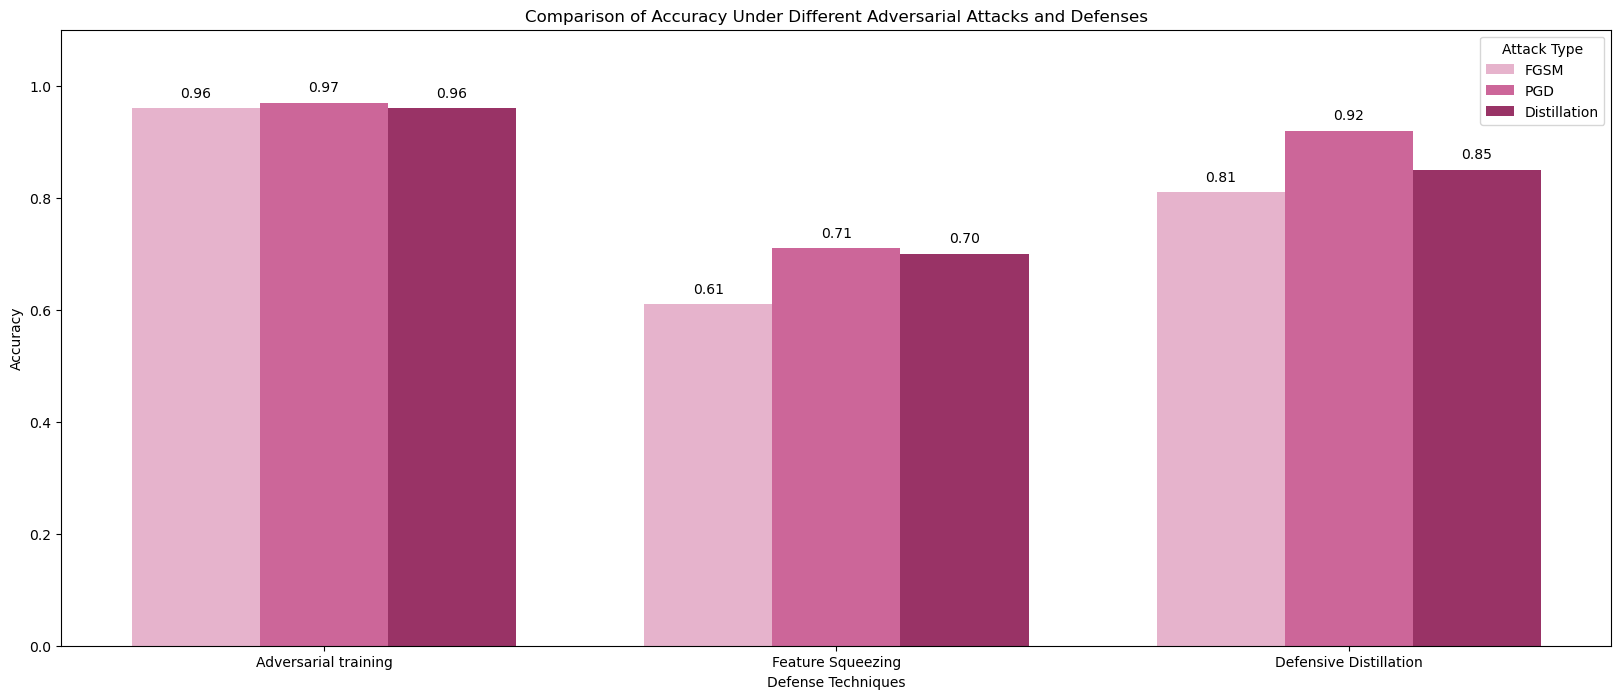

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Sample accuracy data (replace these with your actual accuracy values)
accuracy_data = {
    "FGSM": [0.96, 0.61, 0.81],  # FGSM attack accuracy under each defense: [Input Preprocessing, Defensive Distillation, Gaussian Smoothing]
    "PGD": [0.97, 0.71, 0.92],   # PGD attack accuracy under each defense
    "Distillation": [0.96, 0.70, 0.85]  # DeepFool attack accuracy under each defense
}

# Defense techniques used for each attack
defense_methods = ["Adversarial training","Feature Squeezing","Defensive Distillation"]

# Create bar width and positions for each group
num_defenses = len(defense_methods)
bar_width = 0.25  # Width of each bar
index = np.arange(len(accuracy_data))  # Positions for each attack group

# Plot each defense as a separate set of bars within each attack
plt.figure(figsize=(20, 8))
colors = ["#e6b3cc","#cc6699","#993366"]
for i, (attack, accuracies) in enumerate(accuracy_data.items()):
    # Position each bar based on its index and bar width
    plt.bar(index + i * bar_width, accuracies, width=bar_width, label=f"{attack}",color = colors[i])

# Add labels and title
plt.xlabel("Defense Techniques")
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy Under Different Adversarial Attacks and Defenses")
plt.xticks(index + bar_width, defense_methods)
plt.ylim(0, 1 + 0.1)  # Accuracy scale [0, 1]

# Annotate bars with accuracy values for each attack and defense combination

for i, (attack, accuracies) in enumerate(accuracy_data.items()):
    for j, acc in enumerate(accuracies):
        plt.text(index[j] + i * bar_width, acc + 0.02, f"{acc:.2f}", ha='center')

# Add a legend
plt.legend(title="Attack Type")
plt.show()


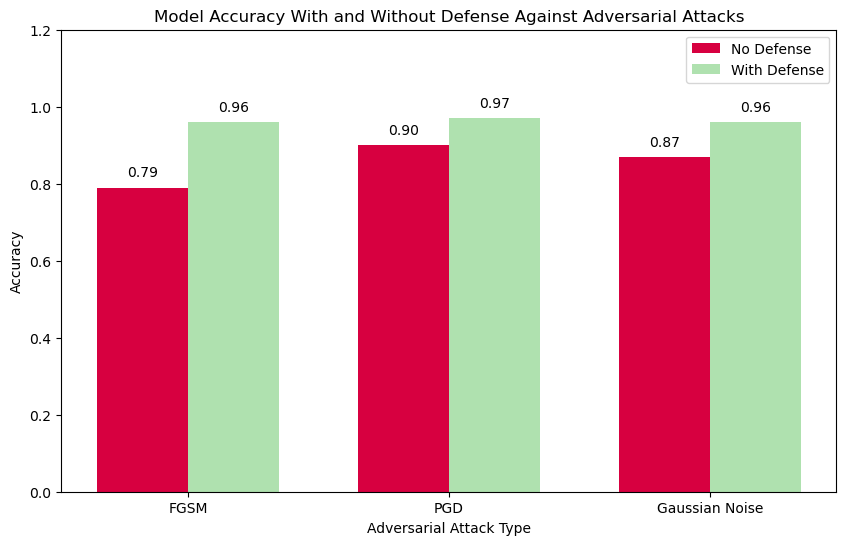

In [5]:
#compare the accuracy without the defense and with the defense  

import matplotlib.pyplot as plt
import numpy as np

# Sample accuracy data (replace these with your actual values)
accuracy_data = {
    "FGSM": {"no_defense": 0.79, "with_defense": 0.96},   # FGSM accuracy without and with defense
    "PGD": {"no_defense": 0.90, "with_defense": 0.97},    # PGD accuracy without and with defense
    "Gaussian Noise": {"no_defense": 0.87, "with_defense": 0.96}  # Gaussian accuracy without and with defense
}

# Prepare data for plotting
attack_types = list(accuracy_data.keys())
no_defense_accuracies = [accuracy_data[attack]["no_defense"] for attack in attack_types]
with_defense_accuracies = [accuracy_data[attack]["with_defense"] for attack in attack_types]

# Bar width and positions
bar_width = 0.35  # Width of each bar
index = np.arange(len(attack_types))  # X locations for the groups

# Plotting the bars
plt.figure(figsize=(10, 6))
bars1 = plt.bar(index, no_defense_accuracies, bar_width, label="No Defense", color="#D70040")
bars2 = plt.bar(index + bar_width, with_defense_accuracies, bar_width, label="With Defense", color="#AFE1AF")

# Add labels and title
plt.xlabel("Adversarial Attack Type")
plt.ylabel("Accuracy")
plt.title("Model Accuracy With and Without Defense Against Adversarial Attacks")
plt.xticks(index + bar_width / 2, attack_types)
plt.ylim(0, 1.2)  # Set y-axis to [0, 1] for accuracy

# Annotate bars with accuracy values
for bar, acc in zip(bars1, no_defense_accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 0.02, f"{acc:.2f}", ha='center', va='bottom')
for bar, acc in zip(bars2, with_defense_accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 0.02, f"{acc:.2f}", ha='center', va='bottom')

# Add legend
plt.legend()
plt.show()
